In [1]:
import json
import os
import pandas as pd
import numpy as np

In [2]:
list_files_example = os.listdir("data_example")
list_files_example.remove(".DS_Store")

In [3]:
data_list = {}

for i, file in enumerate(list_files_example):
    # test uniquement les nouveaux fichiers générés
    if "Hrv" in file:
        with open("data_example/" + file) as f:
            data_list[i] = json.load(f)
            print(file)

HrvNewSample1.json
HrvNewSample2.json
HrvNewSample3.json


In [4]:
def transform_json_data_RrInterval_to_dataframe(json_data):
    data_field = json_data["data"]
    # Split fields in timestamp & value
    df_exploration = pd.DataFrame(list(map(lambda x: x.split(" "), data_field)), 
                                  columns= ["timestamp", "RrInterval"])

    # Cast value as int
    df_exploration["RrInterval"] = df_exploration["RrInterval"].apply(lambda x : int(x))

    # set cleaned timestamp as index
    df_exploration["timestamp"] = pd.to_datetime(df_exploration["timestamp"])
    df_exploration = df_exploration.set_index("timestamp")

    return df_exploration

## Exploration de la cohérence des données extraites

In [5]:
for i in range(4,7):#range(len(data_list)):
    try:
        print()
        print("fichier {}".format(i))
        df = transform_json_data_RrInterval_to_dataframe(data_list[i])
        print("Somme des RrInt (s): " + str(df["RrInterval"].sum() / 1000))
        print("Nombre de RrInt : " + str(df["RrInterval"].count()))
        timedelta = df.index[-1] - df.index[0]
        print("TimeDelta : " + str(timedelta))
        print("En secondes : " + str(timedelta.seconds))
        print(df.resample("1T").count())
        print()
        print("------------------------------------")
    except:
        #data_list[i]
        print("Problem for " + "data_list[" + str(i) + "]")
        print()
        print("------------------------------------")
        pass


fichier 4
Somme des RrInt (s): 790.532
Nombre de RrInt : 1000
TimeDelta : 0 days 00:12:50.070000
En secondes : 770
                     RrInterval
timestamp                      
2018-09-07 17:27:00          55
2018-09-07 17:28:00          71
2018-09-07 17:29:00          70
2018-09-07 17:30:00          71
2018-09-07 17:31:00          70
2018-09-07 17:32:00          84
2018-09-07 17:33:00          81
2018-09-07 17:34:00          82
2018-09-07 17:35:00          78
2018-09-07 17:36:00          80
2018-09-07 17:37:00          81
2018-09-07 17:38:00          86
2018-09-07 17:39:00          82
2018-09-07 17:40:00           9

------------------------------------

fichier 5
Somme des RrInt (s): 744.141
Nombre de RrInt : 1000
TimeDelta : 0 days 00:12:04.685000
En secondes : 724
                     RrInterval
timestamp                      
2018-09-07 17:40:00          71
2018-09-07 17:41:00          82
2018-09-07 17:42:00          82
2018-09-07 17:43:00          83
2018-09-07 17:44:00       

In [17]:
import matplotlib.pyplot as plt

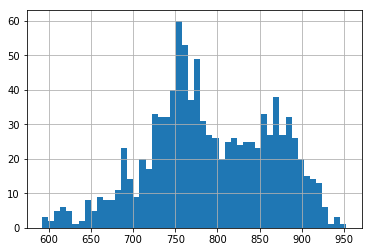

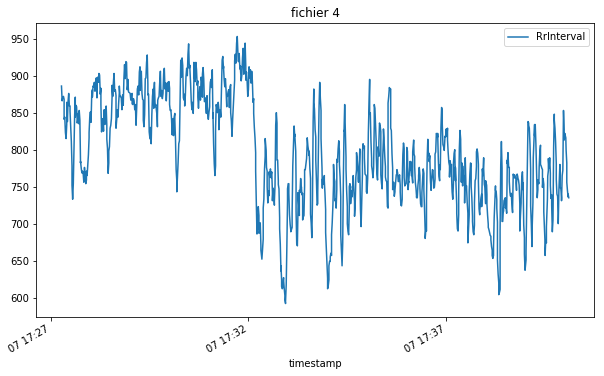

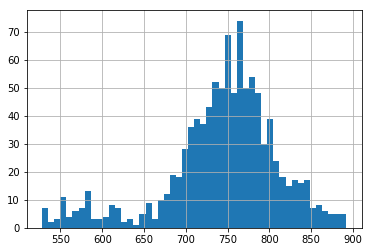

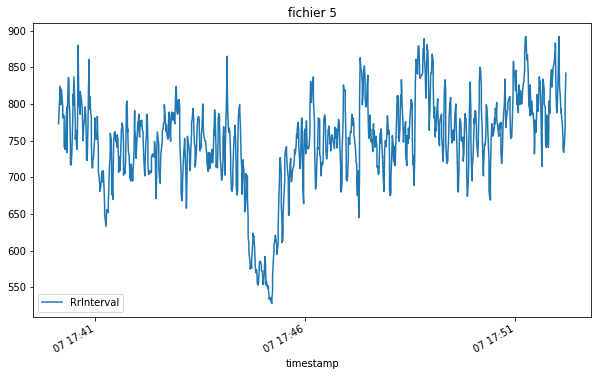

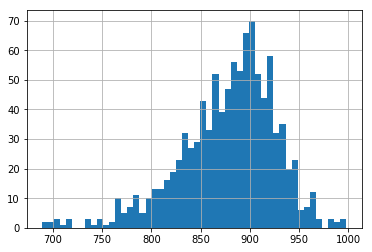

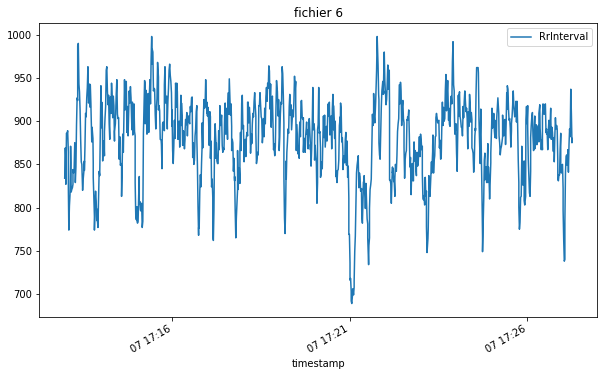

In [21]:
for i in range(4,7):#range(len(data_list)):
    try:
        df = transform_json_data_RrInterval_to_dataframe(data_list[i])
        df["RrInterval"].hist(bins = 50)
        df.plot(figsize=(10, 6), title="fichier {}".format(i))
        plt.show()
    except:
        raise

## Exploration de l'impact des méthodes de suppression d'outliers

In [22]:
def clean_outlier(rr_intervals, low_rri=300, high_rri=2000):
    """
    Function that replace RR Interval outlier by nan

    Arguments
    ---------
    rr_intervals:
    low_rri:
    high_rri:

    Returns
    ---------
    rr_intervals_cleaned - list of RR Intervals without outliers

    """

    # Conversion RrInterval / Heart rate ==> rri (ms) =  1000 / (bpm / 60)
    # rri 2000 => bpm 30 / rri 300 => bpm 200
    rr_intervals_cleaned = [x if high_rri >= x >= low_rri else np.nan for x in rr_intervals]
    nan_count = sum(np.isnan(rr_intervals_cleaned))
    print("{} outlier(s) have been deleted.".format(nan_count))
    return rr_intervals_cleaned

def interpolate_cleaned_outlier(rr_intervals_cleaned):
    """
    Function that interpolate Nan values with linear interpolation

    Arguments
    ---------
    rr_intervals_cleaned:

    Returns
    ---------
    rr_intervals_interpolated
    """
    s = pd.Series(rr_intervals_cleaned)
    rr_intervals_interpolated = s.interpolate(method="linear")
    return rr_intervals_interpolated


def clean_ectopic_beats(rr_intervals, method="Malik", custom_rule=None):
    """
    RR intervals differing by more than the removing_rule from the one proceeding it are removed.

    Arguments
    ---------
    rr_intervals - list of Rr Intervals
    method - method to use to clean outlier. Malik, Kamath, Karlsson, mean_last9 or Custom
    custom_rule - percentage criteria of difference with previous Rr
    Interval at which we consider that it is abnormal

    Returns
    ---------
    nn_intervals - list of NN Interval

    """

    # set first element in list
    nn_intervals = [rr_intervals[0]]
    outlier_count = 0
    previous_outlier = False

    # if method == "Karlsson":
    #     if i == len(rr_intervals)-2:
    #         break
    #     mean_prev_next_rri = (rr_interval + rr_intervals[i + 2]) / 2
    #     if abs(mean_prev_next_rri - rr_intervals[i+1]) < 0.2 * mean_prev_next_rri:
    #         nn_intervals.append(rr_intervals[i+1])
    #     else:
    #         nn_intervals.append(np.nan)
    #         outlier_count += 1
    #         previous_outlier = True
    #
    # return nn_intervals

    if method == "mean_last9":
        nn_intervals = []
        for i, rr_interval in enumerate(rr_intervals):

            if i < 9:
                nn_intervals.append(rr_interval)
                continue

            mean_last_9_elt = np.nanmean(nn_intervals[-9:])
            if abs(mean_last_9_elt - rr_interval) < 0.3 * mean_last_9_elt:
                nn_intervals.append(rr_interval)
            else:
                nn_intervals.append(np.nan)
                outlier_count += 1
                # previous_outlier = True
    else:
        for i, rr_interval in enumerate(rr_intervals[:-1]):

            if previous_outlier:
                nn_intervals.append(rr_intervals[i + 1])
                previous_outlier = False
                continue

            # TO DO pour v2 ... Check si plusieurs outliers consécutifs. Quelle règle appliquer ?
            # while previous_outlier:
            #   j += 1
            #  if is_outlier(rr_interval, rr_intervals[i+1+j]):
            #     nn_intervals.append(np.nan)
            #    continue
            # else:
            #    previous_outlier = False

            if is_outlier(rr_interval, rr_intervals[i + 1], method=method, custom_rule=custom_rule):
                nn_intervals.append(rr_intervals[i + 1])
            else:
                # A débattre, Comment remplacer les outliers ?
                nn_intervals.append(np.nan)
                outlier_count += 1
                previous_outlier = True

    print("{} ectopic beat(s) have been deleted with {} rule.".format(outlier_count, method))

    return nn_intervals


def is_outlier(rr_interval, next_rr_interval, method="Malik", custom_rule=None):
    if method == "Malik":
        return abs(rr_interval - next_rr_interval) <= 0.2 * rr_interval
    elif method == "Kamath":
        return 0 <= (next_rr_interval - rr_interval) <= 0.325 * rr_interval or 0 <= (rr_interval - next_rr_interval) \
               <= 0.245 * rr_interval
    elif method == "custom":
        return abs(rr_interval - next_rr_interval) <= custom_rule * rr_interval
    else:
        raise ValueError("Not a valid method. Please choose Malik or Kamath")


def is_valid_sample(nn_intervals, outlier_count, removing_rule=0.04):
    """
    Test if the sample meet the condition to be used for analysis

    Arguments
    ----------
    nn_intervals - list of Normal to Normal Interval
    outlier_count - count of outliers or ectopic beats removed from the interval
    removing_rule - rule to follow to determine whether the sample is valid or not

    Returns
    ----------
    Boolean - True if sample is valid, False if not
    """
    if outlier_count / len(nn_intervals) > removing_rule:
        print("Too much outlier for analyses ! You should descard the sample")
        return  False
    if len(nn_intervals) < 240:
        print("Not enough Heart beat for Nyquist criteria ! ")
        return False
    return True

In [ ]:
for i in range(len(data_list)):
    try:
        print()
        print("fichier {}".format(i))
        df = transform_json_data_RrInterval_to_dataframe(data_list[i])
        print("Somme des RrInt (s): " + str(df["RrInterval"].sum() / 1000))
        print("Nombre de RrInt : " + str(df["RrInterval"].count()))
        timedelta = df.index[-1] - df.index[0]
        print("TimeDelta : " + str(timedelta))
        print("En secondes : " + str(timedelta.seconds))
        # Clean Outlier Method
        df_cleaned = clean_outlier(df["RrInterval"])
        # clean ectopic beats
        df_malik = clean_ectopic_beats(df["RrInterval"], method="Malik")
        df_Kamath = clean_ectopic_beats(df["RrInterval"], method="Kamath")
        df_mean_last9 = clean_ectopic_beats(df["RrInterval"], method="mean_last9")
        print()
        print("------------------------------------")
    except:
        print("Problem for " + "data_list[" + str(i) + "]")
        print()
        print("------------------------------------")
        pass